

#<center>Final Project: OpenAI Gym<center>
##<center>Lunar Landing<center>

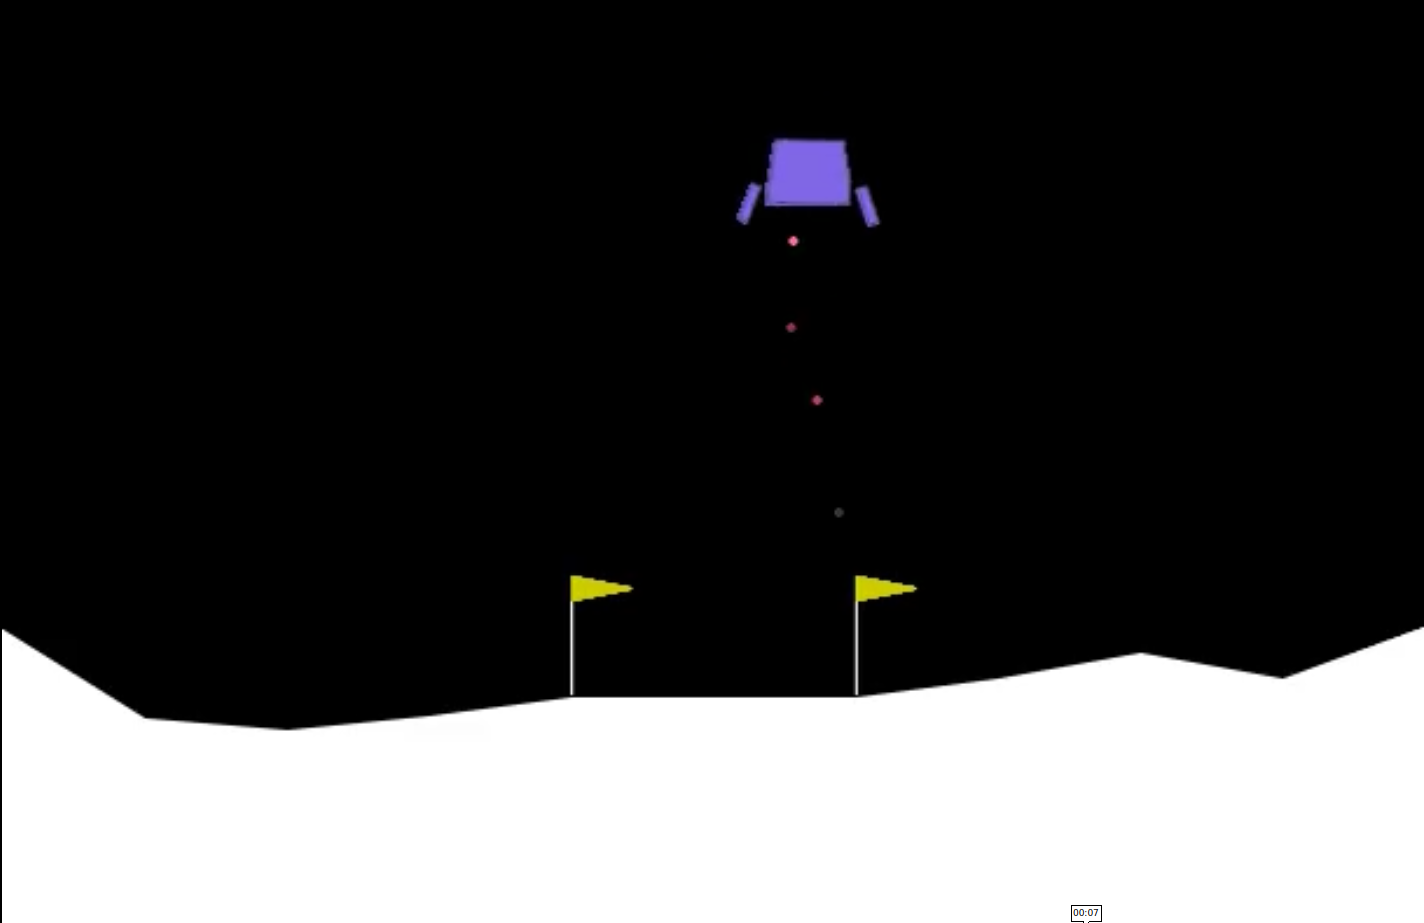





##<center>Jessica Carpenter<center>
##<center>Intro to AI<center>
##<center>Fall 2023<center>

## Resources



https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

https://github.com/yuchen071/DQN-for-LunarLander-v2/blob/main/LunarLander.ipynb

https://www.gocoder.one/blog/rl-tutorial-with-openai-gym/

https://www.youtube.com/watch?v=F1Qm8TmDW84

https://github.com/yuchen071/DQN-for-LunarLander-v2/blob/main/LunarLander.ipynb


Another helpful source- comments on Piazza!

## Project Goal

In this project, we will create an environment and train an agent using artificial intelligence techniques. In our coursework, we discussed Q-learning which will be utilized here. Through my research while planning this project, I found a method that uses Q-learning combined with deep neural networks, called Deep Q-learning. This algorithm allows machines to learn how to take optimal actions in complex environments through trial and error, using a deep neural network to estimate the long-term rewards of different chioces.

## Project Code

In [8]:
# install dependencies
# import libraries
!pip install swig
!pip install gym[box2d]
!pip install keras-rl
import gym
import torch
import torch.nn as nn
import torch.optim as optim

import random
import numpy as np
import gym
import gym.spaces as sp
from gym.wrappers import RecordVideo
from tqdm import trange
from time import sleep
from collections import namedtuple, deque
import matplotlib.pyplot as plt

# set up device and environment
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

env = gym.make("LunarLander-v2")


In [28]:
# Policy Network
# This class defines a Q-network for Deep Q-Learning (DQN).
# This is our neural network.
class QNet(nn.Module):

    def __init__(self, n_states, n_actions, n_hidden=64):
        super(QNet, self).__init__()

        # We will define network layers here with ReLU activation and linear output
        self.fc = nn.Sequential(
            nn.Linear(n_states, n_hidden),     # First hidden layer (in_features -> n_hidden)
            nn.ReLU(),                         # ReLU activation
            nn.Linear(n_hidden, n_hidden),     # Second hidden layer (n_hidden -> n_hidden)
            nn.ReLU(),                         # ReLU activation
            nn.Linear(n_hidden, n_actions)     # Output layer (n_hidden -> n_actions)
            )

    # Take in a state and output the estimated Q-values for each action
    def forward(self, x):
        return self.fc(x)

# We define a class to implement a Deep Q-Learning algorithm.
# Inspiration for class from https://github.com/yuchen071/DQN-for-LunarLander-v2/blob/main/LunarLander.ipynb
class DQN():

    # Initialize the DQN agent with hyperparameters and networks
    def __init__(self, n_states, n_actions, batch_size=64, lr=1e-4, gamma=0.99, mem_size=int(1e5), learn_step=5, tau=1e-3):
        # hyperparamters
        self.n_states = n_states
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.gamma = gamma
        self.learn_step = learn_step
        self.tau = tau

        # Q-networks model
        self.net_eval = QNet(n_states, n_actions).to(device)
        self.net_target = QNet(n_states, n_actions).to(device)
        self.optimizer = optim.Adam(self.net_eval.parameters(), lr=lr)
        self.criterion = nn.MSELoss()

        # Replay memory and update counter
        self.memory = ReplayBuffer(n_actions, mem_size, batch_size)
        self.counter = 0    # update cycle counter

    # Epsilon-greedy action selection based on the current state and exploration rate.
    # Our agent will take advantage of priot knowledge and exploration to lok for better options
    # The approach will select the action with the highest reward most of the time.
    def getAction(self, state, epsilon):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)

        # Switch eval/train mode for target network evaluation
        self.net_eval.eval()
        with torch.no_grad():
            action_values = self.net_eval(state)
        self.net_eval.train()

        # Epsilon-greedy action selection
        if random.random() < epsilon:
            action = random.choice(np.arange(self.n_actions))
        else:
            action = np.argmax(action_values.cpu().data.numpy())

        return action

    # Adds a new experience to the replay memory and triggers learning updates if necessary.
        # state (np.ndarray): Current state of the environment.
        # action (int): Action taken by the agent.
        # reward (float): Reward received for taking the action.
        # next_state (np.ndarray): State following the taken action.
        # done (bool): Whether the episode ended after taking the action.
    def save2memory(self, state, action, reward, next_state, done):
        # Add the experience to the replay memory
        self.memory.add(state, action, reward, next_state, done)
        # update counter and check if we reached the trigger
        self.counter += 1
        if self.counter % self.learn_step == 0:
            if len(self.memory) >= self.batch_size:
                # sample a batch of experiences and start learning
                experiences = self.memory.sample()
                self.learn(experiences)

    # Update Q-network based on a batch of sampled experiences from the replay memory
    def learn(self, experiences):

        # states (torch.Tensor): Batch of current states.
        # actions (torch.Tensor): Batch of actions taken.
        # rewards (torch.Tensor): Batch of rewards received.
        # next_states (torch.Tensor): Batch of next states encountered.
        # dones (torch.Tensor): Batch of flags indicating episode termination.
        states, actions, rewards, next_states, dones = experiences
        # Compute target Q-values using the target network and max operation
        q_target = self.net_target(next_states).detach().max(axis=1)[0].unsqueeze(1)
        # Calculate Bellman equation target values with γ discount factor
        # Use negative rewards for terminal states to indicate their finality
        # This is our target, if terminal then y_j = rewards
        y_j = rewards + self.gamma * q_target * (1 - dones)
        # Extract Q-values of chosen actions from the eval network
        q_eval = self.net_eval(states).gather(1, actions)

        # apply optimizer step to update the weights in our network
        loss = self.criterion(q_eval, y_j)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # soft update target network- apply optimizer
        self.softUpdate()

    # gradually update the target network toward our parameters
    # we use weighted averages of the eval parameters and the current target
    def softUpdate(self):
        for eval_param, target_param in zip(self.net_eval.parameters(), self.net_target.parameters()):
            target_param.data.copy_(self.tau*eval_param.data + (1.0-self.tau)*target_param.data)

# Define a class to store experiences for later sampling
class ReplayBuffer():
    def __init__(self, n_actions, memory_size, batch_size):
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.memory = deque(maxlen = memory_size)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    # find hte current number of experiences
    def __len__(self):
        return len(self.memory)
    # add a new experience and replace the oldest element (if full)
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    # sample a batch of experiences from the buffer memory
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        # these are our return tuple elements: batches of current experiences
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

In [33]:
# this is our training function for our agent
# We are trying to achieve an average score of 200
def landing_trainer(env, agent, n_episodes=2000, max_steps=1000, eps_start=1.0, eps_end=0.1, eps_decay=0.995, target=250, chkpt=False):

        # env: Gym environment for the Lunar Lander game.
        # agent: The DQN agent to train.
        # n_episodes (int, optional): Maximum number of episodes to train for (default: 2000).
        # max_steps (int, optional): Maximum number of steps allowed per episode (default: 1000).
        # eps_start (float, optional): Initial exploration rate (epsilon-greedy policy) (default: 1.0).
        # eps_end (float, optional): Minimum exploration rate (default: 0.1).
        # eps_decay (float, optional): Decay factor for epsilon (default: 0.995).
        # target (int, optional): Target average score for early stopping (default: 200).
        # chkpt (bool, optional): Whether to save the agent's network weights after training (default: False).

    # initialize variables
    score_hist = []
    epsilon = eps_start

    # set up of video clip maker so we can see our progress
    env = gym.make("LunarLander-v2", render_mode='rgb_array', new_step_api=True)
    env = RecordVideo(env, 'video')

    # set up a line graph to compare each episode
    bar_format = '{l_bar}{bar:10}| {n:4}/{total_fmt} [{elapsed:>7}<{remaining:>7}, {rate_fmt}{postfix}]'
    pbar = trange(n_episodes, unit="ep", bar_format=bar_format, ascii=True)

    # loop through episodes
    for idx_epi in pbar:
        state = env.reset()
        score = 0
        # loop through steps
        for idx_step in range(max_steps):
          # choose greedy policy
            action = agent.getAction(state, epsilon)
            # take next action and observe state and reward
            next_state, reward, done, _ = env.step(action)
            # store experience
            agent.save2memory(state, action, reward, next_state, done)
            # update state and score
            state = next_state
            score += reward

            if done:
                break

        # track our progress and update epsilon so we can find the best model
        score_hist.append(score)
        score_avg = np.mean(score_hist[-100:])
        epsilon = max(eps_end, epsilon*eps_decay)

        # update progress bar and check stopping condition
        pbar.set_postfix_str(f"Score: {score: 7.2f}, 100 score avg: {score_avg: 7.2f}")
        pbar.update(0)
        if len(score_hist) >= 100:
            if score_avg >= target:
                break
    # print message if complete
    if (idx_epi+1) < n_episodes:
        print("\nTarget achieved!")
    else:
        print("\nComplete!")

    if chkpt:
        torch.save(agent.net_eval.state_dict(), 'checkpoint.pth')
    # retirn list of episode scores
    return score_hist

# test our Lunar Lander
def testLander(env, agent, loop=3):
    # loop through test iterations, reset for each loop, choose an action and evaluate
    for i in range(loop):
        state = env.reset()
        for idx_step in range(500):
            action = agent.getAction(state, epsilon=0)
            env.render()
            state, reward, done, _ = env.step(action)
            if done:
                break
    env.close()

# plot our scores so we can see the learning progress
def plotScore(scores):
    plt.figure()
    plt.plot(scores)
    plt.title("Score History")
    plt.xlabel("Episodes")
    plt.show()

In [34]:
BATCH_SIZE = 128        # batch size
LR = 1e-3               # learning rate
EPISODES = 1000          # number of episodes to train for
TARGET_SCORE = 250.     # early training stop at avg score of last 100 episodes
GAMMA = 0.99            # discount factor
MEMORY_SIZE = 10000     # max memory buffer size
LEARN_STEP = 5          # how often to learn
TAU = 1e-3              # for soft update of target parameters
SAVE_CHKPT = False      # save trained network .pth file

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
100%|##########| 1000/1000 [  52:54<  00:00,  3.17s/ep, Score:  233.01, 100 score avg:  214.24]



Complete!


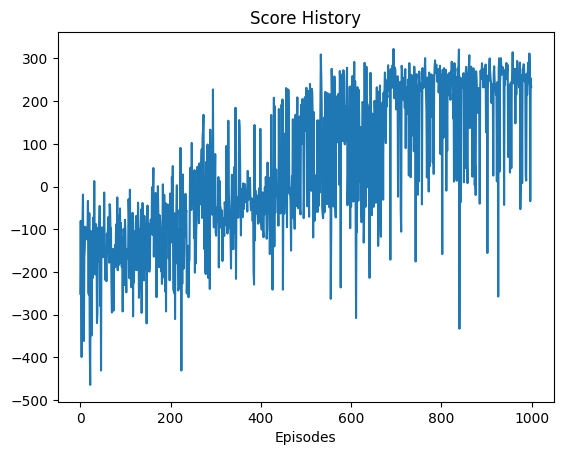

In [35]:
# Extract the size of the state and action spaces from the environment
num_states = env.observation_space.shape[0]
num_actions = env.action_space.n

# Create a DQN agent with specified hyperparameters
agent = DQN(
    n_states = num_states,     # number of input features (dimensions of the state space)
    n_actions = num_actions,   # number of possible actions the agent can take
    batch_size = BATCH_SIZE,   # number of experiences sampled from memory for each learning update
    lr = LR,                   # learning rate for the optimizer
    gamma = GAMMA,             # discount factor for future rewards
    mem_size = MEMORY_SIZE,    # maximum number of experiences stored in the replay memory
    learn_step = LEARN_STEP,   # frequency of network updates based on collected experiences
    tau = TAU,                 # soft update parameter for target network synchronization
    )

# Train the agent with the `landing_trainer` function and return the score history
score_hist = landing_trainer(env, agent, n_episodes=EPISODES, target=TARGET_SCORE, chkpt=SAVE_CHKPT)
# Visualize the training progress
plotScore(score_hist)

# Clear GPU memory if training on CUDA device
if str(device) == "cuda":
    torch.cuda.empty_cache()

In [ ]:
testLander(env, agent, loop=10)